<a href="https://colab.research.google.com/github/Tatiana-Andrade/Banco/blob/main/YoloProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CONFIGS

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.9 MB/s eta 0:00:00


In [ ]:
import random
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Obtener Dataset

In [ ]:
# Ruta del archivo ZIP en tu Drive
zip_path = '/content/drive/MyDrive/dataset3.zip'

# Carpeta donde se descomprimirá
extract_path = '/content/drive/MyDrive/unzip_dataset3/'

# Descomprimir
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset descomprimido en:", extract_path)

Dataset descomprimido en: /content/drive/MyDrive/unzip_dataset3/


### Aumentar Dataset

In [ ]:
import os
import cv2
import albumentations as A
from tqdm import tqdm
import shutil

# Rutas
base_path = '/content/drive/MyDrive/unzip_dataset3/train'
images_path = os.path.join(base_path, 'images')
labels_path = os.path.join(base_path, 'labels')

augmented_path = '/content/drive/MyDrive/unzip_dataset3/train_augmented'
os.makedirs(os.path.join(augmented_path, 'images'), exist_ok=True)
os.makedirs(os.path.join(augmented_path, 'labels'), exist_ok=True)

# Copiar imágenes originales al nuevo dataset
for img_file in os.listdir(images_path):
    shutil.copy(os.path.join(images_path, img_file), os.path.join(augmented_path, 'images', img_file))
for lbl_file in os.listdir(labels_path):
    shutil.copy(os.path.join(labels_path, lbl_file), os.path.join(augmented_path, 'labels', lbl_file))

# Definir pipeline de augmentaciones
transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.HorizontalFlip(p=0.4),
    A.VerticalFlip(p=0.1),
    A.Blur(blur_limit=3, p=0.2),
    A.RandomScale(scale_limit=0.2, p=0.3),
    A.HueSaturationValue(p=0.3)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Crear imágenes aumentadas
for img_name in tqdm(os.listdir(images_path)):
    if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        continue

    img_path = os.path.join(images_path, img_name)
    label_path = os.path.join(labels_path, os.path.splitext(img_name)[0] + '.txt')

    # Cargar imagen y etiquetas
    image = cv2.imread(img_path)
    if image is None:
        continue
    h, w, _ = image.shape
    with open(label_path, 'r') as f:
        lines = f.readlines()

    boxes = []
    class_labels = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 5:
            class_labels.append(int(parts[0]))
            boxes.append([float(x) for x in parts[1:5]])

    # Aplicar transformaciones (2 augmentaciones por imagen)
    for i in range(2):
        transformed = transform(image=image, bboxes=boxes, class_labels=class_labels)
        aug_img = transformed['image']
        aug_boxes = transformed['bboxes']
        aug_labels = transformed['class_labels']

        new_img_name = os.path.splitext(img_name)[0] + f'_aug{i}.jpg'
        new_lbl_name = os.path.splitext(img_name)[0] + f'_aug{i}.txt'

        # Guardar imagen aumentada
        cv2.imwrite(os.path.join(augmented_path, 'images', new_img_name), aug_img)

        # Guardar etiquetas aumentadas
        with open(os.path.join(augmented_path, 'labels', new_lbl_name), 'w') as f:
            for label, box in zip(aug_labels, aug_boxes):
                f.write(f"{label} {' '.join(map(str, box))}\n")

print("✅ Dataset aumentado creado correctamente en:", augmented_path)

100%|██████████| 49/49 [00:03<00:00, 14.88it/s]

✅ Dataset aumentado creado correctamente en: /content/drive/MyDrive/unzip_dataset3/train_augmented


In [ ]:
import yaml

# Ruta donde guardar el nuevo data.yaml
yaml_path = '/content/drive/MyDrive/unzip_dataset3/data.yaml'
data_yaml = {
    'train': '/content/drive/MyDrive/unzip_dataset3/train_augmented/images',
    'val': '/content/drive/MyDrive/unzip_dataset3/valid/images',
    'nc': 3,
    'names': ['apple', 'banana', 'orange']
}

# Guardar
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print(f"Archivo data.yaml generado correctamente en: {yaml_path}")

Archivo data.yaml generado correctamente en: /content/drive/MyDrive/unzip_dataset3/data.yaml


In [ ]:
!cat /content/drive/MyDrive/unzip_dataset3/data.yaml

train: /content/drive/MyDrive/unzip_dataset3/train_augmented/images
val: /content/drive/MyDrive/unzip_dataset3/valid/images
nc: 3
names:
- apple
- banana
- orange


##Descripción del proceso de etiquetado de datos



El etiquetado de datos consistió en asignar manualmente una categoría o clase a cada objeto presente en las imágenes del dataset, con el fin de entrenar el modelo de detección basado en YOLOv8.
Este proceso es fundamental, ya que define qué debe aprender la red neuronal a reconocer dentro de cada imagen.

Para este proyecto, se trabajó con tres clases principales: “apple”, “banana” y “orange” (aunque los nombres pueden variar según el conjunto de datos).
Cada imagen fue analizada individualmente, y en ella se dibujaron cajas delimitadoras (bounding boxes) alrededor de cada objeto de interés.
Estas cajas indican la posición y el tamaño del objeto dentro de la imagen, permitiendo que el modelo aprenda la relación espacial entre los píxeles y su respectiva categoría.

En el caso de nuestro código el etiquetado fue automatico en la creación de carpetas

## Implementación YOLOv8 para detección de objetos

Se carga el modelo YOLOv8 y se entrena con base a los datos de configuración (mapeo de rutas para los directorios de train, test y validation) que se encuentran en el archivo "data.yaml". Se ejecutan 75 epocas y se establece el tamaño de las imagenes a 640 píxeles.

In [ ]:
# Cargar el modelo YOLO preentrenado
yolo_model = YOLO('yolov8s.pt')

# Entrenar el modelo en tu dataset
yolo_model.train(
    data='/content/drive/MyDrive/unzip_dataset3/data.yaml',
    epochs=75,
    imgsz=640,
    batch=8,
    flipud=0.1,           # menos volteo vertical
    fliplr=0.3,           # volteo horizontal moderado
    mosaic=0.7,           # mantiene variabilidad
    mixup=0.0,
    degrees=10,           # rotación leve
    translate=0.1,        # desplazamiento leve
    scale=0.5,            # escalado moderado
    shear=0.0,
    workers=2,
    augment=True,
    name='train'
)

Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/unzip_dataset3/data.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.3, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=0.7, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, pl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e12a8582330>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

##Justificación Yolov8

Para este proyecto se seleccionó YOLOv8 , desarrollado por Ultralytics, debido a que representa una de las versiones más avanzadas y optimizadas de la familia YOLO para tareas de detección de objetos.

YOLOv8 ofrece un equilibrio excepcional entre precisión, velocidad y facilidad de implementación, lo cual lo hace especialmente adecuado para proyectos sencillos y de investigación aplicada

## Evaluar el modelo

Se realiza la evaluación del modelo usando el conjunto de validación y se extraen los resultados de precision (accuracy) y loss rate.

In [ ]:
# Evaluación en el set de validación
metrics = yolo_model.val()
print(metrics)

Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 7.3±3.2 MB/s, size: 26.8 KB)
val: Scanning /content/drive/MyDrive/unzip_dataset3/valid/labels.cache... 4 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4/4 7.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 5.3it/s 0.2s
                   all          4          8      0.907      0.667      0.839      0.634
                     a          1          1      0.924          1      0.995      0.895
                     b          4          6          1          0      0.526       0.21
                     o          1          1      0.797          1      0.995      0.796
Speed: 1.5ms preprocess, 27.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /content/runs/detect/val
ultr

##Guardamos el modelo

## Gráficas accuracy y Loss

Se leen los datos de resultados de entrenamiento y grafica cómo cambian la pérdida y la precisión del modelo a lo largo del tiempo.

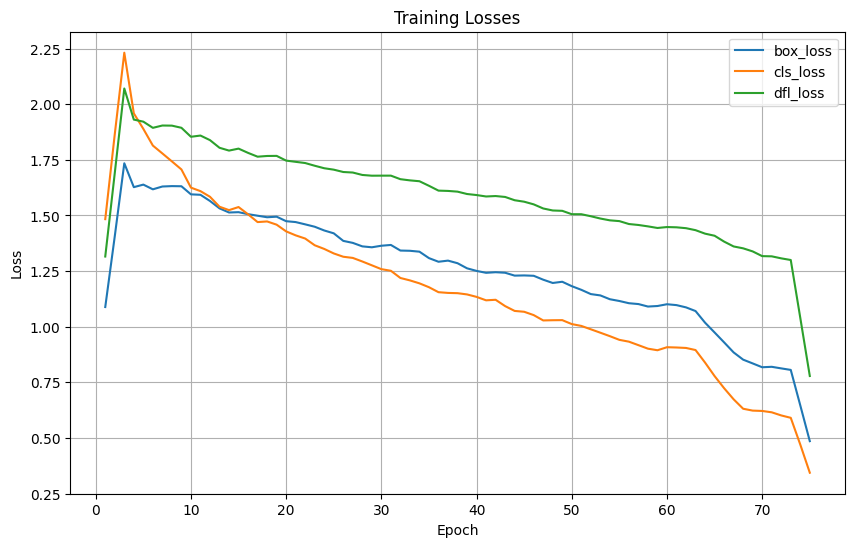

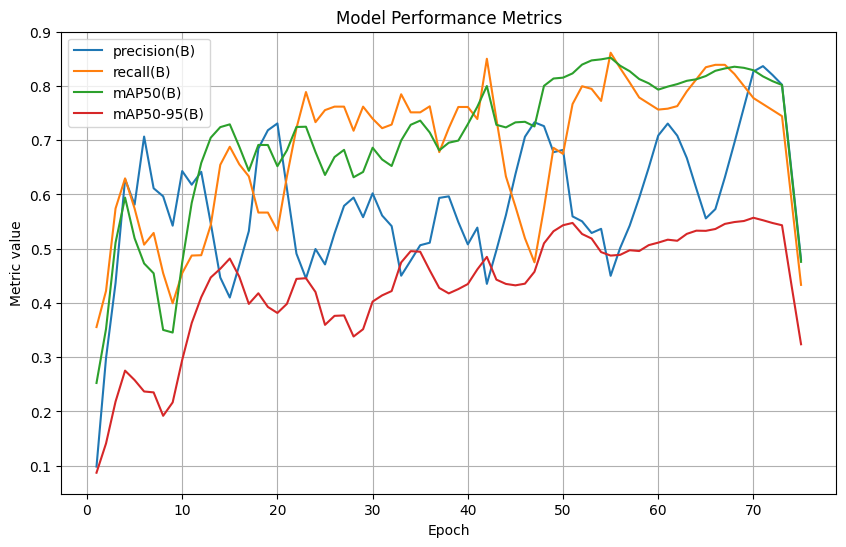

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ruta del archivo CSV del último entrenamiento
results_path = '/content/runs/detect/train/results.csv'

# Leer los resultados
results = pd.read_csv(results_path)

# Aplicar suavizado (rolling window)
def smooth(y, box_pts=5):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# === Gráfica 1: Pérdidas ===
plt.figure(figsize=(10,6))
for col in ['train/box_loss', 'train/cls_loss', 'train/dfl_loss']:
    if col in results.columns:
        plt.plot(results['epoch'], smooth(results[col]), label=col.split('/')[-1])
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# === Gráfica 2: Métricas de desempeño ===
plt.figure(figsize=(10,6))
for metric in ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']:
    if metric in results.columns:
        plt.plot(results['epoch'], smooth(results[metric]), label=metric.split('/')[-1])
plt.title('Model Performance Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.legend()
plt.grid(True)
plt.show()

## Pruebas

Se selecciona aleatoriamente un conjunto de imágenes del directorio de test y, para cada una, se ejecuta el modelo YOLO para realizar predicciones, mostrando los resultados sobre cada imagen.


image 1/1 /content/drive/MyDrive/unzip_dataset3/test/images/apple_65_jpg.rf.0e918923e749e444cb71b6d38843ad8c.jpg: 640x640 11 apples, 16.5ms
Speed: 2.7ms preprocess, 16.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


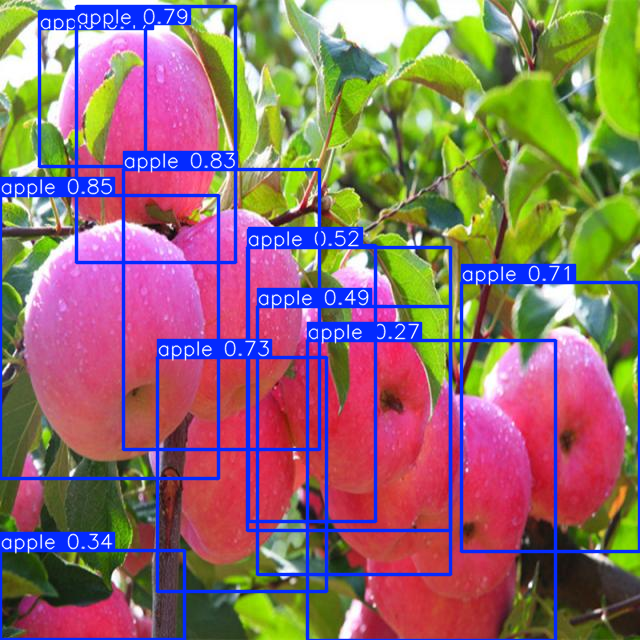


image 1/1 /content/drive/MyDrive/unzip_dataset3/test/images/mixed_24_jpg.rf.a41057dd88c81c73787eb62c7a688746.jpg: 640x640 1 apple, 2 bananas, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


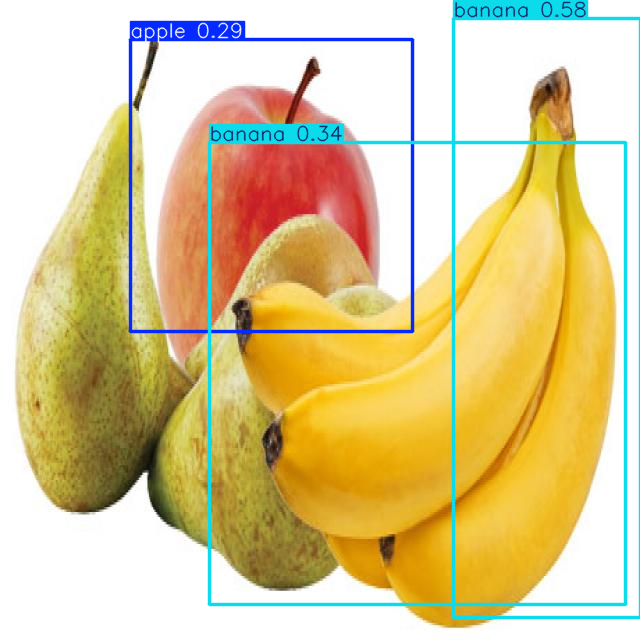


image 1/1 /content/drive/MyDrive/unzip_dataset3/test/images/mixed_22_jpg.rf.1f64dc4c99b62e4eabc20d96d80ae00a.jpg: 640x640 2 apples, 3 bananas, 1 orange, 16.3ms
Speed: 1.9ms preprocess, 16.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


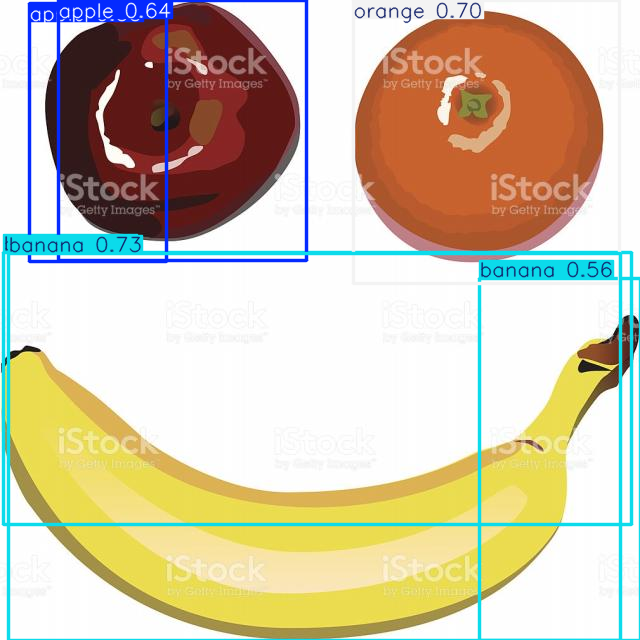


image 1/1 /content/drive/MyDrive/unzip_dataset3/test/images/mixed_23_jpg.rf.9751712085899758f2d6ef672eb58bec.jpg: 640x640 2 apples, 1 banana, 1 orange, 16.3ms
Speed: 1.9ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


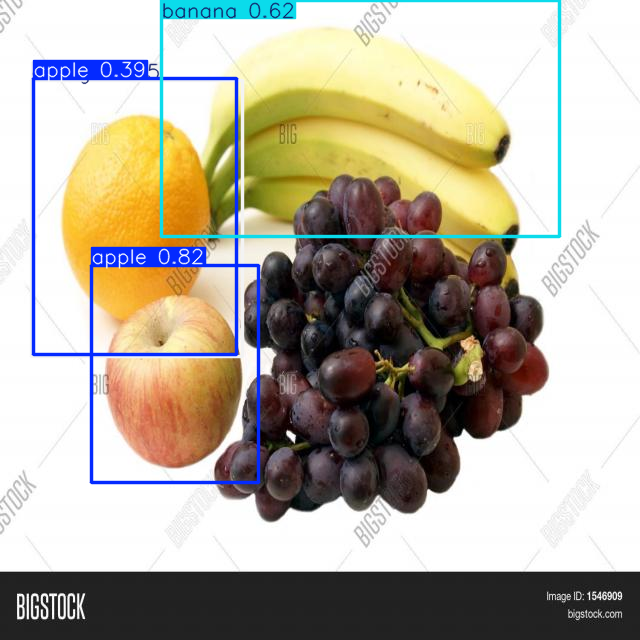


image 1/1 /content/drive/MyDrive/unzip_dataset3/test/images/mixed_25_jpg.rf.27775be690cc6e6329d58e3c93669144.jpg: 640x640 1 apple, 1 orange, 16.3ms
Speed: 2.0ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


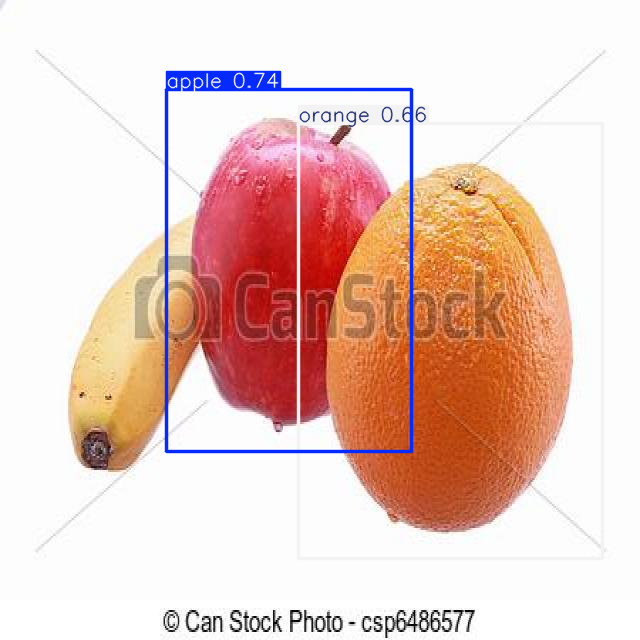

In [12]:

                    # Define la ruta de las imágenes de prueba
test_images_path = '/content/drive/MyDrive/unzip_dataset3/test/images/'  # Cambia a tu ruta real

# Número de imágenes aleatorias para mostrar
num_images_to_show = 5

# Obtiene una lista de archivos de imagen en el conjunto de test
all_images = [os.path.join(test_images_path, img) for img in os.listdir(test_images_path)]
random_images = random.sample(all_images, num_images_to_show)

for i, img_path in enumerate(random_images):
    # Realiza la predicción en la imagen
    results = yolo_model(img_path)

    for r in results:
      r.show()  # Mostrar la imagen con los resultados